In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pylab
import seaborn as sns
import os
from os import path
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from scipy.cluster.hierarchy import fcluster, fclusterdata, linkage, dendrogram 
import matplotlib.patches as patches
from copy import deepcopy
import pickle
from sklearn.metrics import r2_score

# common formatting
plt.style.use('../synthetic-enhancer-footprinting.mplstyle')

import sys  
# sys.path.insert(0, '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/code/amplicon-smf/workflow/scripts')
sys.path.insert(0, '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/partition_function_model_outputs/231114_first_pass_at_reunning_everything/amplicon-smf/workflow/scripts')

import common, fit_partition_function_model_v3


import importlib
importlib.reload(common)
importlib.reload(fit_partition_function_model_v3)
%matplotlib inline

import matplotlib.font_manager

output_path = '/oak/stanford/groups/wjg/jschaepe/projects/smf/synthetic-enhancer-footprinting-outputs/'

fontsize=6
markersize=20
legend_fontsize = 5

In [53]:
# load all smf data

# all_smf_table_path = '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/all_smf_experiments_aggregator/231112_all_smf_experiments.v2.txt'
all_smf_table_path = '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/all_smf_experiments_aggregator/231114_all_smf_experiments.v3.txt'

smf_data = pd.read_table(all_smf_table_path)

In [54]:
smf_data.head()

,sample,amplicon,n_tfbs,background,molecules,avg_tf_bound,fraction_promoters_active,binding_histogram,background_silenced_fraction,fraction_enhancers_tf_bound,...,dox_washout_time,drug,drug_time_min,drug_washout_time,ifn,ifn_conc,ifn_time_min,fastq,benchling file,flowdata
0,L240_gSMF51_opJS4_b1_-dox,opJS4_8x_TetO_21bp_no_CG,8,0.0,4638,0.609099,0.056490,"0:0.5658,1:0.2967,2:0.1093,3:0.0209,4:0.0060,5...",0.058215,0.434239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,L240_gSMF51_opJS4_b1_-dox,opJS4_7x_TetO_21bp_no_CG,7,0.0,8038,0.536203,0.063200,"0:0.6010,1:0.2869,2:0.0909,3:0.0174,4:0.0035,5...",0.053371,0.398980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L240_gSMF51_opJS4_b1_-dox,opJS4_6x_TetO_21bp_no_CG,6,0.0,9208,0.373588,0.070591,"0:0.7033,1:0.2306,2:0.0570,3:0.0076,4:0.0014,5...",0.051477,0.296699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,L240_gSMF51_opJS4_b1_-dox,opJS4_5x_TetO_21bp_no_CG,5,0.0,2331,0.215358,0.053625,"0:0.8031,1:0.1802,2:0.0150,3:0.0017",0.087516,0.196911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,L240_gSMF51_opJS4_b1_-dox,opJS4_4x_TetO_21bp_no_CG,4,0.0,3603,0.167638,0.038857,"0:0.8468,1:0.1391,2:0.0139,3:0.0003",0.096309,0.153206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
data = smf_data.loc[(smf_data.pool=='opJS45')&(smf_data.dox_conc==1000)&(smf_data.dox_time_min==1440)&(smf_data.effector.isna())&(smf_data.drug.isna())]

data = data.loc[~data.experiment_name.isin(['doxdose1'])]
# data = data.loc[~data.experiment_name.isin(['doxdose1','doxtimecourse'])]
# data = data.loc[~data.experiment_name.isin(['doxdose1','drug_timecourse'])]

data['experiment_name'].unique(), data['sample'].unique()


(array(['doxtimecourse', 'drug_timecourse'], dtype=object),
 array(['L281_gSMF92_opJS45_b1_24hrdox', 'L289_gSMF100_opJS45_b2_24hrdox',
        'gSMF166-opJS45ctcf-24hr-1000ngdox-b1',
        'gSMF174-opJS45ctcf-24hr-1000ngdox-b2'], dtype=object))

In [56]:
# go back and figure out which reps to rerun the model on
# also write model that fits nuc energy across experiments
# also write model that can incorporate data from more than one sample

partition_function_dir = '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/partition_function_model_outputs/231114_first_pass_at_reunning_everything'

samples = data['sample'].unique().tolist()

model_params = []

for sample in samples:
#     print(sample)
    model_outputs = pd.read_table(path.join(partition_function_dir, '{}.fit.opjs4.independent_fit.txt'.format(sample)), header=None, index_col=0)
    tf_e, nuc_e, delta_e = model_outputs.loc['E_TF',1], model_outputs.loc['E_nuc',1], model_outputs.loc['deltaE_nuc_when_TF_bound',1]
    model_params.append({'sample': sample, 'tf_e': tf_e, 'nuc_e': nuc_e, 'delta_e': delta_e})
    
params = pd.DataFrame(model_params)

# average the params and rerun the prediction
with open(path.join(partition_function_dir,'timecourse_drugtimecourse.opjs4.independent_fit.txt'), 'w') as outfile:
    outfile.write('{}\t{}\n'.format('E_TF', params.mean().loc['tf_e']))
    outfile.write('{}\t{}\n'.format('E_nuc', params.mean().loc['nuc_e']))
    outfile.write('{}\t{}\n'.format('deltaE_nuc_when_TF_bound', params.mean().loc['delta_e']))


In [57]:
b0_vp48params = params.copy()
b0_vp48params

,sample,tf_e,nuc_e,delta_e
0,L281_gSMF92_opJS45_b1_24hrdox,-0.963902,-1.592853,-0.903931
1,L289_gSMF100_opJS45_b2_24hrdox,-0.940575,-1.508305,-0.875436
2,gSMF166-opJS45ctcf-24hr-1000ngdox-b1,-0.758057,-1.228047,-0.807753
3,gSMF174-opJS45ctcf-24hr-1000ngdox-b2,-0.755088,-1.252516,-0.814654


In [58]:
# also do for 2-param model

model_params_2param = []

for sample in samples:
#     print(sample)
    model_outputs = pd.read_table(path.join(partition_function_dir, '{}.fit.opjs4.independent_fit.2param.txt'.format(sample)), header=None, index_col=0)
    tf_e, nuc_e = model_outputs.loc['E_TF',1], model_outputs.loc['E_nuc',1]
    model_params_2param.append({'sample': sample, 'tf_e': tf_e, 'nuc_e': nuc_e})
    
params_2param = pd.DataFrame(model_params_2param)

# average the params and rerun the prediction
with open(path.join(partition_function_dir,'timecourse_drugtimecourse.opjs4.independent_fit.2param.txt'), 'w') as outfile:
    outfile.write('{}\t{}\n'.format('E_TF', params_2param.mean().loc['tf_e']))
    outfile.write('{}\t{}\n'.format('E_nuc', params_2param.mean().loc['nuc_e']))


In [59]:
# also do the same thing on opJS5

partition_function_dir5 = '/oak/stanford/groups/wjg/bgrd/papers/synthetic_enhancer_footprinting/data/partition_function_model_outputs/231204_opjs5_partition_function'

samples = data['sample'].unique().tolist()

# opJS5b1
model_params = []

for sample in samples:
#     print(sample)
    model_outputs = pd.read_table(path.join(partition_function_dir5, '{}.fit.opjs5_b1.independent_fit.txt'.format(sample)), header=None, index_col=0)
    tf_e, nuc_e, delta_e = model_outputs.loc['E_TF',1], model_outputs.loc['E_nuc',1], model_outputs.loc['deltaE_nuc_when_TF_bound',1]
    model_params.append({'sample': sample, 'tf_e': tf_e, 'nuc_e': nuc_e, 'delta_e': delta_e})
    
params = pd.DataFrame(model_params)

# average the params and rerun the prediction
with open(path.join(partition_function_dir5,'timecourse_drugtimecourse.opjs5_b1.independent_fit.txt'), 'w') as outfile:
    outfile.write('{}\t{}\n'.format('E_TF', params.mean().loc['tf_e']))
    outfile.write('{}\t{}\n'.format('E_nuc', params.mean().loc['nuc_e']))
    outfile.write('{}\t{}\n'.format('deltaE_nuc_when_TF_bound', params.mean().loc['delta_e']))
    
# opJS5b2
model_params = []

for sample in samples:
#     print(sample)
    model_outputs = pd.read_table(path.join(partition_function_dir5, '{}.fit.opjs5_b2.independent_fit.txt'.format(sample)), header=None, index_col=0)
    tf_e, nuc_e, delta_e = model_outputs.loc['E_TF',1], model_outputs.loc['E_nuc',1], model_outputs.loc['deltaE_nuc_when_TF_bound',1]
    model_params.append({'sample': sample, 'tf_e': tf_e, 'nuc_e': nuc_e, 'delta_e': delta_e})
    
params = pd.DataFrame(model_params)

# average the params and rerun the prediction
with open(path.join(partition_function_dir5,'timecourse_drugtimecourse.opjs5_b2.independent_fit.txt'), 'w') as outfile:
    outfile.write('{}\t{}\n'.format('E_TF', params.mean().loc['tf_e']))
    outfile.write('{}\t{}\n'.format('E_nuc', params.mean().loc['nuc_e']))
    outfile.write('{}\t{}\n'.format('deltaE_nuc_when_TF_bound', params.mean().loc['delta_e']))


In [60]:
# load in simulated data summary stats
summary_stats = pd.read_table(path.join(partition_function_dir, 'timecourse_drugtimecourse.opjs4.independent_fit.summary_stats.txt'))
summary_stats

,amplicon,n_tfbs,avg_tf_bound,fraction_enhancers_tf_bound,binding_histogram
0,opJS4_8x_TetO_21bp_no_CG,8,3.2554,0.8391,"4:0.1901,3:0.1657,0:0.1609,5:0.1537,2:0.1214,6..."
1,opJS4_7x_TetO_21bp_no_CG,7,2.9657,0.8162,"4:0.1865,0:0.1838,3:0.1761,5:0.1476,2:0.1395,6..."
2,opJS4_6x_TetO_21bp_no_CG,6,2.1285,0.6864,"0:0.3136,3:0.1648,2:0.1541,4:0.1478,1:0.0983,5..."
3,opJS4_5x_TetO_21bp_no_CG,5,1.3375,0.5284,"0:0.4716,2:0.1560,3:0.1404,1:0.1168,4:0.0885,5..."
4,opJS4_4x_TetO_21bp_no_CG,4,0.8890,0.4089,"0:0.5911,2:0.1456,1:0.1156,3:0.1086,4:0.0391"
5,opJS4_3x_TetO_21bp_no_CG,3,0.5255,0.2922,"0:0.7078,2:0.1191,1:0.1160,3:0.0571"
6,opJS4_2x_TetO_21bp_no_CG,2,0.1900,0.1392,"0:0.8608,1:0.0884,2:0.0508"
7,opJS4_1x_TetO_21bp_no_CG,1,0.0503,0.0503,"0:0.9497,1:0.0503"
8,opJS4_0x_TetO_21bp_no_CG,0,0.0000,0.0000,0:1.0000


In [61]:
# 2-param
summary_stats_2param = pd.read_table(path.join(partition_function_dir, 'timecourse_drugtimecourse.opjs4.independent_fit.2param.summary_stats.txt'))
summary_stats_2param

,amplicon,n_tfbs,avg_tf_bound,fraction_enhancers_tf_bound,binding_histogram
0,opJS4_8x_TetO_21bp_no_CG,8,2.6977,0.9224,"2:0.2276,3:0.2168,1:0.1778,4:0.1542,5:0.0926,0..."
1,opJS4_7x_TetO_21bp_no_CG,7,2.5357,0.9079,"2:0.2387,3:0.2179,1:0.1875,4:0.1462,0:0.0921,5..."
2,opJS4_6x_TetO_21bp_no_CG,6,2.1230,0.8605,"2:0.2491,1:0.2362,3:0.1917,0:0.1395,4:0.1154,5..."
3,opJS4_5x_TetO_21bp_no_CG,5,1.6567,0.7856,"1:0.2818,2:0.2484,0:0.2144,3:0.1617,4:0.0755,5..."
4,opJS4_4x_TetO_21bp_no_CG,4,1.3162,0.7124,"1:0.3011,0:0.2876,2:0.2483,3:0.1335,4:0.0295"
5,opJS4_3x_TetO_21bp_no_CG,3,1.0486,0.6525,"0:0.3475,1:0.3388,2:0.2313,3:0.0824"
6,opJS4_2x_TetO_21bp_no_CG,2,0.5639,0.4402,"0:0.5598,1:0.3165,2:0.1237"
7,opJS4_1x_TetO_21bp_no_CG,1,0.2181,0.2181,"0:0.7819,1:0.2181"
8,opJS4_0x_TetO_21bp_no_CG,0,0.0000,0.0000,0:1.0000


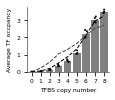

In [62]:
fig, ax = plt.subplots(figsize=(4/2.5,3/2.5))

background = 0

sns.barplot(data=data.loc[data.background==0], x='n_tfbs', y='avg_tf_bound', ax=ax, color='0.5', ci=None)
sns.stripplot(data=data.loc[data.background==0], x='n_tfbs', y='avg_tf_bound', ax=ax, color='k', size=2)
sns.lineplot(data=summary_stats, x='n_tfbs', y='avg_tf_bound', ax=ax, color='k', ls='--', linewidth=1)
sns.lineplot(data=summary_stats_2param, x='n_tfbs', y='avg_tf_bound', ax=ax, color='0.25', ls='--', linewidth=1)

ax.set_xlabel('TFBS copy number', fontsize = fontsize)
ax.set_xlim(-0.5,8.5)
ax.set_ylim(0,3.8)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([0,1,2,3,4,5,6,7,8], fontsize = fontsize)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels([0,1,2,3], fontsize = fontsize)
ax.set_ylabel('Average TF occpancy', fontsize = fontsize)
ax.set_box_aspect(0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend()
# ax.get_legend().set_visible(False)

plt.savefig('{}/fig2_plots/occupancy_vs_tfbs.b{}.pdf'.format(output_path, background), dpi=300)

In [63]:
data_vals = data.loc[data.background==0].groupby('n_tfbs')['avg_tf_bound'].mean().sort_index()
# data_vals
model_vals = summary_stats.set_index('n_tfbs')['avg_tf_bound'].sort_index()
model_vals2 = summary_stats_2param.set_index('n_tfbs')['avg_tf_bound'].sort_index()
# model_vals

r2_score(data_vals, model_vals), r2_score(data_vals, model_vals2)


(0.985095642502771, 0.8390299134237217)

In [64]:
def parse_binding_histogram(hist_str):
    d = {}
    
    for kv in hist_str.split(','):
        k, v = kv.split(':')
        d[int(k)] = float(v)
        
    return d

# parse_binding_histogram(summary_stats.loc[summary_stats.amplicon=='opJS4_8x_TetO_21bp_no_CG','binding_histogram'].values[0])
    

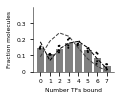

In [65]:
fig, ax = plt.subplots(figsize=(4/2.5,3/2.5))

amp = 'opJS4_7x_TetO_21bp_no_CG'

histograms = pd.DataFrame([parse_binding_histogram(hs) for hs in data.loc[(data.background==0)&(data.amplicon==amp), 'binding_histogram']]).melt(var_name='tf_bound', value_name='prob')
histograms_simulated = pd.DataFrame([parse_binding_histogram(hs) for hs in summary_stats.loc[(summary_stats.amplicon==amp), 'binding_histogram']]).melt(var_name='tf_bound', value_name='prob')
histograms_simulated_2param = pd.DataFrame([parse_binding_histogram(hs) for hs in summary_stats_2param.loc[(summary_stats_2param.amplicon==amp), 'binding_histogram']]).melt(var_name='tf_bound', value_name='prob')

sns.barplot(data=histograms, x='tf_bound', y='prob', ax=ax, color='0.5', ci=None)
sns.stripplot(data=histograms, x='tf_bound', y='prob', ax=ax, color='k', size=2)
sns.lineplot(data=histograms_simulated, x='tf_bound', y='prob', ax=ax, color='k', ls='--', linewidth=1)
sns.lineplot(data=histograms_simulated_2param, x='tf_bound', y='prob', ax=ax, color='0.25', ls='--', linewidth=1)

ax.set_xlabel('Number TFs bound', fontsize = fontsize)
ax.set_ylim(0,0.4)
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels([0,1,2,3,4,5,6,7], fontsize = fontsize)
ax.set_yticks([0,0.1,0.2,0.3])
ax.set_yticklabels([0,0.1,0.2,0.3], fontsize = fontsize)
ax.set_ylabel('Fraction molecules', fontsize = fontsize)
ax.set_box_aspect(0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend()
# ax.get_legend().set_visible(False)

plt.savefig('{}/fig2_plots/binding_histogram.{}.pdf'.format(output_path, amp), dpi=300)


In [66]:
data_vals = histograms.groupby('tf_bound')['prob'].mean().sort_index()
model_vals = histograms_simulated.set_index('tf_bound')['prob'].sort_index()
model_vals2 = histograms_simulated_2param.set_index('tf_bound')['prob'].sort_index()

r2_score(data_vals, model_vals), r2_score(data_vals, model_vals2)


tf_bound
0    0.147975
1    0.107025
2    0.141525
3    0.177575
4    0.172775
5    0.134375
6    0.085650
7    0.033050
Name: prob, dtype: float64
tf_bound
0    0.1838
1    0.0687
2    0.1395
3    0.1761
4    0.1865
5    0.1476
6    0.0789
7    0.0189
Name: prob, dtype: float64
tf_bound
0    0.0921
1    0.1875
2    0.2387
3    0.2179
4    0.1462
5    0.0789
6    0.0331
7    0.0056
Name: prob, dtype: float64


(0.7929140928424427, -0.7197463022590531)

In [48]:
# get fit params and reshape
params = b0_vp48params
params['nuc_energy_when_tf_bound'] = params['nuc_e'] - params['delta_e']
melted_params = params.melt(value_vars=['tf_e', 'nuc_e', 'nuc_energy_when_tf_bound'], value_name='energy', var_name='parameter')

In [49]:
params

,sample,tf_e,nuc_e,delta_e,nuc_energy_when_tf_bound
0,L281_gSMF92_opJS45_b1_24hrdox,-0.963902,-1.592853,-0.903931,-0.688921
1,L289_gSMF100_opJS45_b2_24hrdox,-0.940575,-1.508305,-0.875436,-0.632869
2,gSMF166-opJS45ctcf-24hr-1000ngdox-b1,-0.758057,-1.228047,-0.807753,-0.420294
3,gSMF174-opJS45ctcf-24hr-1000ngdox-b2,-0.755088,-1.252516,-0.814654,-0.437862


/tmp/ipykernel_21472/4073637436.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['E_TF', 'E_Nuc', 'Delta E_Nuc - Delta E_remodel'], fontsize = fontsize)


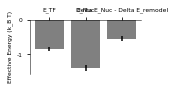

In [50]:
fig, ax = plt.subplots(figsize=(2,1))

ps = ['tf_e', 'nuc_e', 'nuc_energy_when_tf_bound']
means = params.set_index('sample').mean().loc[ps]
sems = params.set_index('sample').sem().loc[ps]

ax.bar(ps, means, yerr=sems, color='0.5')

# ax.set_xlabel('', fontsize = fontsize)
# ax.set_xlim(-0.5,8.5)
# # ax.set_ylim(0,20500)
# ax.set_xticks([0,2,4,6,8])
# ax.set_xticklabels(['$\Delta E_{TF}$', '$\Delta E_{Nuc}$', '$\Delta E_{Nuc} - \Delta E_{remodel}$'], fontsize = fontsize)
ax.set_xticklabels(['E_TF', 'E_Nuc', 'Delta E_Nuc - Delta E_remodel'], fontsize = fontsize)
ax.set_yticks([-1,0])
ax.set_yticklabels([-1,0], fontsize = fontsize)
ax.set_ylabel('Effective Energy (k_B T)', fontsize = fontsize)
# ax.set_box_aspect(0.8)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend()
# ax.get_legend().set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# plt.savefig('{}/fig2_plots/partition_function_model_outputs.b{}.pdf'.format(output_path, background), dpi=300)
plt.savefig('{}/fig2_plots/partition_function_model_outputs.b{}.pdf'.format(output_path, background), dpi=300)


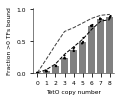

In [85]:
# now also plot fraction >1 TF bound with model fits for supp

fig, ax = plt.subplots(figsize=(4/2.5,3/2.5))

background = 0

sns.barplot(data=data.loc[data.background==0], x='n_tfbs', y='fraction_enhancers_tf_bound', ax=ax, color='0.5', ci=None)
sns.stripplot(data=data.loc[data.background==0], x='n_tfbs', y='fraction_enhancers_tf_bound', ax=ax, color='k', size=2)
sns.lineplot(data=summary_stats, x='n_tfbs', y='fraction_enhancers_tf_bound', ax=ax, color='k', ls='--', linewidth=1)
sns.lineplot(data=summary_stats_2param, x='n_tfbs', y='fraction_enhancers_tf_bound', ax=ax, color='0.25', ls='--', linewidth=1)

ax.set_xlabel('TetO copy number', fontsize = fontsize)
ax.set_xlim(-0.5,8.5)
ax.set_ylim(0,1.03)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([0,1,2,3,4,5,6,7,8], fontsize = fontsize)
ax.set_yticks([0.0,0.5,1.0])
ax.set_yticklabels([0.0,0.5,1.0], fontsize = fontsize)
ax.set_ylabel('Fraction >0 TFs bound', fontsize = fontsize)
ax.set_box_aspect(0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend()
# ax.get_legend().set_visible(False)

plt.savefig('{}/fig2_plots/fig2_supplement/enhancertfbound_vs_tfbs.b{}.pdf'.format(output_path, background), dpi=300)


In [90]:
data_vals = data.loc[data.background==0].groupby('n_tfbs')['fraction_enhancers_tf_bound'].mean().sort_index()
# data_vals
model_vals = summary_stats.set_index('n_tfbs')['fraction_enhancers_tf_bound'].sort_index()
model_vals2 = summary_stats_2param.set_index('n_tfbs')['fraction_enhancers_tf_bound'].sort_index()
# model_vals

r2_score(data_vals, model_vals), r2_score(data_vals, model_vals2)


(0.9860108711727718, 0.4447140221229856)